# BioscrapeCOBRA: a hyrid composite of chemical reaction networks with flux balance analysis

## Overview
This notebook combines a chemical reaction network model with a flux balance analysis model, and a physics engine

* SBML
* BiGG model

In [1]:
#@title install vivarium libraries

#Uncomment in Colab Below

"""
%%capture
!pip install git+https://github.com/vivarium-collective/vivarium-notebooks
!pip install vivarium-core==0.1.5
!pip install vivarium-cobra==0.0.6
!pip install vivarium-pymunk==0.0.2
!pip install vivarium-bioscrape
"""

In [2]:
#@title imports
import numpy as np
import pylab as plt

# process/composition interface
from vivarium.core.process import (
    Process, Deriver, Composite,
)

# helper functions for composition
from vivarium.core.composition import (
    simulate_process_in_experiment,
    simulate_compartment_in_experiment,
    compartment_in_experiment,
    compose_experiment,
    FACTORY_KEY,
)

# other vivarium imports
from vivarium.core.experiment import Experiment, pp
from vivarium.library.units import units

# vivarium plotting functions
from vivarium.plots.simulation_output import plot_simulation_output
from vivarium.plots.agents_multigen import plot_agents_multigen
from vivarium.plots.topology import plot_topology

# import processes and composites
from vivarium.processes.tree_mass import TreeMass
from vivarium.processes.divide_condition import DivideCondition
from vivarium.processes.meta_division import MetaDivision

# vivarium-cobra processes
from vivarium_cobra.processes.volume import Volume
from vivarium_cobra.composites.cobra_composite import CobraComposite
from vivarium_cobra.processes.dynamic_fba import (
    DynamicFBA, 
    get_iAF1260b_config, 
    print_growth
)

# vivarium-bioscrape processes
from vivarium_bioscrape.processes.bioscrape import Bioscrape


In [3]:
# plotting function for metabolism output
def plot_metabolism(data, ncol=2):
    original_fontsize = plt.rcParams['font.size']
    plt.rcParams.update({'font.size': 9})
    
    # initialize subplots
    n_rows = 2
    n_cols = 2
    fig = plt.figure(figsize=(n_cols * 7, n_rows * 3))
    grid = plt.GridSpec(n_rows, n_cols)
    
    time_vec = data['time']
    
    # mass
    ax = fig.add_subplot(grid[0, 0])  
    ax.plot(time_vec, data['global'][('mass', 'femtogram')], label = 'mass')
    ax.set_title('total compartment mass (fg)')
    ax.set_xlabel('time (sec)')
#   ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=ncol)
    
    # external
    ax = fig.add_subplot(grid[0, 1])  
    for mol_id, series in data['external'].items():
        if sum(series) != 0.0:
            ax.plot(time_vec, series, label = mol_id)
    ax.set_title('external concentrations (log)')
    ax.set_yscale('log')
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=ncol)
    
    # internal
    ax = fig.add_subplot(grid[1, 1])  
    for mol_id, series in data['internal_counts'].items():
        if sum(series) != 0.0:
            ax.plot(time_vec, series, label = mol_id)
    ax.set_title('internal molecule counts (log)')
    ax.set_xlabel('time (sec)')
    ax.set_yscale('log')
    fig.tight_layout()
    plt.rcParams.update({'font.size': original_fontsize})

# Flux Balance Analysis with COBRA

 * This process is a wrapper for the popular FBA solver [COBRA](https://cobrapy.readthedocs.io/en/latest/).
 * Metabolism is initialized with a [BiGG metabolic model](http://bigg.ucsd.edu) called *iAF1260b*, which has 2382 reactions, 1261 genes, and 166 metabolites.

In [4]:
compartment_in_experiment
# get the configuration for the iAF1260b BiGG model
cobra_config = get_iAF1260b_config()
cobra_config.update({'time_step': 10})
config = {'cobra': cobra_config}   

# load it into DynamicFBA
metabolism = CobraComposite(config)

# get the model's initial state
initial_state = metabolism.initial_state({}) 

# run simulation
sim_settings = {
    'initial_state': initial_state,
    'total_time': 500}
cobra_timeseries = simulate_compartment_in_experiment(metabolism, sim_settings)


Experiment ID: b74070d8-666e-11eb-8614-6c2b5976b3a5
Created: 02/03/2021 at 14:25:27
Completed in 5.59 seconds


volume growth: 1.1433345369510877
mass growth: 1.1433345369510879


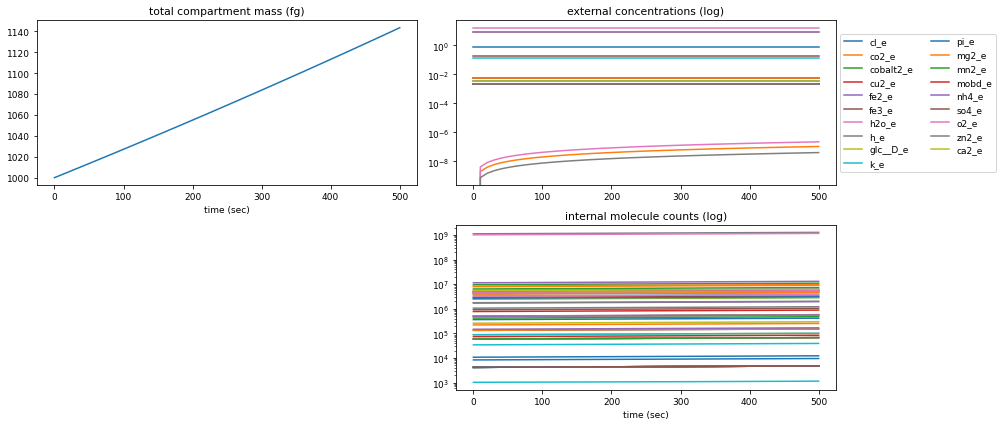

In [5]:
print_growth(cobra_timeseries['global'])
plot_metabolism(cobra_timeseries)

# Chemical Reaction Network with SBML 

In [6]:


# initialize Bioscrape process
time_step = 10

#This will configure a deterministic model as a system of ODEs
deterministic_bioscrape_config = {
            'sbml_file': 'LacOperon_deterministic.xml',
            'stochastic': False,
            'initial_volume': 1,
            'internal_dt': 0.01,
            'time_step':time_step}


bioscrape_process_deterministic = Bioscrape(deterministic_bioscrape_config)

In [7]:
#Run the simulation
total_time = 10000

# initial state
initial_state = bioscrape_process_deterministic.initial_state()

# run simulation
settings = {
    'total_time': total_time,
    'timestep':time_step,
    'initial_state': initial_state,
    'display_info': False,
    'progress_bar': False}
bioscrape_timeseries_deterministic = simulate_process_in_experiment(bioscrape_process_deterministic, settings)



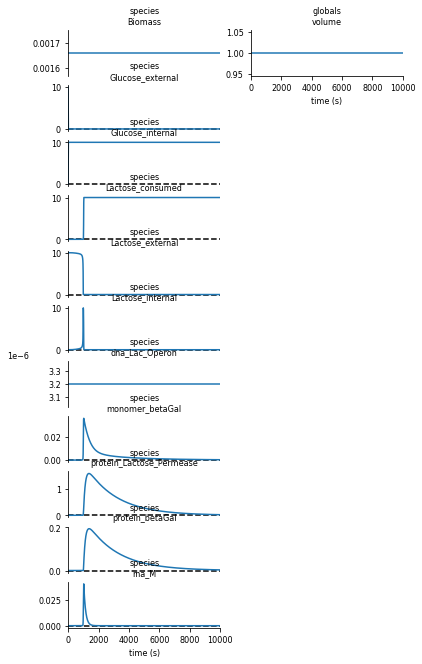

In [8]:
fig = plot_simulation_output(bioscrape_timeseries_deterministic)

In [9]:
#This will configure a stochastic model using the Gillespie SSA algorithm
stochastic_bioscrape_config = {
            'sbml_file': 'LacOperon_stochastic.xml',
            'stochastic': True,
            'safe_mode':True,
            'initial_volume': 1,
            'internal_dt': 0.01,
            'time_step':time_step}


bioscrape_process_stochastic = Bioscrape(stochastic_bioscrape_config)

In [10]:
#Run the simulation
total_time = 10000

# initial state
initial_state = bioscrape_process_stochastic.initial_state()
print(initial_state)

# run simulation
settings = {
    'total_time': total_time,
    'initial_state': initial_state,
    'display_info': False,
    'progress_bar': False}
bioscrape_timeseries_stochastic = simulate_process_in_experiment(bioscrape_process_stochastic, settings)

print("Complete!")

{'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 5000000.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}}
states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 5000000.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'B

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.0
states {'species': {'rna_M': 0.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 150

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_G': 15055.0

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 2.0, 'Lactose_external': 4994431.0, 'Lactose_internal': 5567.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 11.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 2.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': -3.0, 'protein_betaGal': 1.0, 'Lactose_external': -3302.0, 'Lactose_internal': 3300.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 5.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K

states {'species': {'rna_M': 2.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 5.0, 'Lactose_external': 4955154.0, 'Lactose_internal': 44632.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 34.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 214.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 1.0, 'Lactose_external': -10756.0, 'Lactose_internal': 10680.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 4.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 76.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 12.0, 'Lactose_external': 4838475.0, 'Lactose_internal': 159473.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 76.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 2052.0}, 'delta_species': {'rna_M': -1.0, 'monomer_betaGal': -2.0, 'protein_betaGal': 2.0, 'Lactose_external': -25523.0, 'Lactose_internal': 24944.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 7.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 579.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 29

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 14.0, 'Lactose_external': 4660335.0, 'Lactose_internal': 331550.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 91.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 8115.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -31783.0, 'Lactose_internal': 30450.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 1333.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 290

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 15.0, 'Lactose_external': 4469572.0, 'Lactose_internal': 512922.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 100.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 17506.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': -1.0, 'protein_betaGal': 1.0, 'Lactose_external': -33224.0, 'Lactose_internal': 31541.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 7.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 1683.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 17.0, 'Lactose_external': 4250959.0, 'Lactose_internal': 718161.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 109.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 30880.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -37459.0, 'Lactose_internal': 34921.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2538.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 17.0, 'Lactose_external': 4026832.0, 'Lactose_internal': 925695.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 108.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 47473.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -37003.0, 'Lactose_internal': 34023.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2980.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 16.0, 'Lactose_external': 3804740.0, 'Lactose_internal': 1130031.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 108.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 65229.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -36898.0, 'Lactose_internal': 33959.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2939.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 16.0, 'Lactose_external': 3583763.0, 'Lactose_internal': 1332655.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 108.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 83582.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -36808.0, 'Lactose_internal': 33700.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 3108.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 15.0, 'Lactose_external': 3363001.0, 'Lactose_internal': 1534959.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 108.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 102040.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -36599.0, 'Lactose_internal': 33484.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 3115.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L':

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 15.0, 'Lactose_external': 3143423.0, 'Lactose_internal': 1735563.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 108.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 121014.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -36698.0, 'Lactose_internal': 33353.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 3345.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L':

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 15.0, 'Lactose_external': 2924462.0, 'Lactose_internal': 1935135.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 107.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 140403.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -36441.0, 'Lactose_internal': 33176.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 3265.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L':

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 15.0, 'Lactose_external': 2708786.0, 'Lactose_internal': 2130877.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 107.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 160337.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -35759.0, 'Lactose_internal': 32382.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 3377.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L':

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 15.0, 'Lactose_external': 2494614.0, 'Lactose_internal': 2324480.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 106.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 180906.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -35279.0, 'Lactose_internal': 31853.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 3426.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L':

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 15.0, 'Lactose_external': 2282322.0, 'Lactose_internal': 2515779.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 106.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 201899.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -35246.0, 'Lactose_internal': 31735.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 3511.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L':

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 15.0, 'Lactose_external': 2073330.0, 'Lactose_internal': 2703567.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 105.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 223103.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -34645.0, 'Lactose_internal': 31167.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 3478.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L':

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 15.0, 'Lactose_external': 1870164.0, 'Lactose_internal': 2884971.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 102.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 244865.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -33576.0, 'Lactose_internal': 29904.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': -1.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 3672.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 15.0, 'Lactose_external': 1672309.0, 'Lactose_internal': 3061105.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 101.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 266586.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -32773.0, 'Lactose_internal': 29193.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 3580.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L':

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 14.0, 'Lactose_external': 1481272.0, 'Lactose_internal': 3230344.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 98.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 288384.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': -1.0, 'Lactose_external': -31573.0, 'Lactose_internal': 28082.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 3491.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L':

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 14.0, 'Lactose_external': 1295819.0, 'Lactose_internal': 3395211.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 97.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 308970.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -30673.0, 'Lactose_internal': 27253.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 3420.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 14.0, 'Lactose_external': 1115099.0, 'Lactose_internal': 3555007.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 96.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 329894.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -29839.0, 'Lactose_internal': 26322.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 3517.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 14.0, 'Lactose_external': 938334.0, 'Lactose_internal': 3710664.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 96.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 351002.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -29051.0, 'Lactose_internal': 25627.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 3424.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 13.0, 'Lactose_external': 767834.0, 'Lactose_internal': 3860124.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 93.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 372042.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': -1.0, 'Lactose_external': -27616.0, 'Lactose_internal': 24258.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': -1.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 3358.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L':

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 13.0, 'Lactose_external': 608760.0, 'Lactose_internal': 3999101.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 92.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 392139.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -25820.0, 'Lactose_internal': 22545.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 3275.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 13.0, 'Lactose_external': 458461.0, 'Lactose_internal': 4129307.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 92.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 412232.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -24344.0, 'Lactose_internal': 20988.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 3356.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 11.0, 'Lactose_external': 320947.0, 'Lactose_internal': 4248512.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 91.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 430541.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -21900.0, 'Lactose_internal': 18985.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2915.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 11.0, 'Lactose_external': 202860.0, 'Lactose_internal': 4349572.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 89.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 447568.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -18059.0, 'Lactose_internal': 15211.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': -1.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2848.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 11.0, 'Lactose_external': 110915.0, 'Lactose_internal': 4424396.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 89.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 464689.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -13158.0, 'Lactose_internal': 10332.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2826.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 11.0, 'Lactose_external': 49912.0, 'Lactose_internal': 4468197.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 89.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 481891.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -7856.0, 'Lactose_internal': 4952.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2904.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 11.0, 'Lactose_external': 19454.0, 'Lactose_internal': 4481383.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 87.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 499163.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -3382.0, 'Lactose_internal': 513.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': -2.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2869.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 11.0, 'Lactose_external': 7829.0, 'Lactose_internal': 4475883.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 86.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 516288.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -1253.0, 'Lactose_internal': -1601.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2854.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 10.0, 'Lactose_external': 3788.0, 'Lactose_internal': 4462995.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 85.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 533217.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': -1.0, 'Lactose_external': -450.0, 'Lactose_internal': -2180.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2630.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 10.0, 'Lactose_external': 2458.0, 'Lactose_internal': 4448633.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 84.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 548909.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -136.0, 'Lactose_internal': -2542.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2678.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 29000

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 10.0, 'Lactose_external': 2014.0, 'Lactose_internal': 4433781.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 83.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 564205.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -57.0, 'Lactose_internal': -2499.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2556.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 290000

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 10.0, 'Lactose_external': 1816.0, 'Lactose_internal': 4418528.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 83.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 579656.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -15.0, 'Lactose_internal': -2524.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2539.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 290000

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 10.0, 'Lactose_external': 1828.0, 'Lactose_internal': 4403078.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 82.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 595094.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 26.0, 'Lactose_internal': -2593.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2567.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 10.0, 'Lactose_external': 1711.0, 'Lactose_internal': 4387872.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 81.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 610417.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -13.0, 'Lactose_internal': -2590.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2603.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 290000

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 10.0, 'Lactose_external': 1728.0, 'Lactose_internal': 4372548.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 81.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 625724.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -27.0, 'Lactose_internal': -2538.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2565.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 290000

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 10.0, 'Lactose_external': 1700.0, 'Lactose_internal': 4357185.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 79.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 641115.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -35.0, 'Lactose_internal': -2576.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2611.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 290000

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 10.0, 'Lactose_external': 1710.0, 'Lactose_internal': 4341668.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 79.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 656622.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -22.0, 'Lactose_internal': -2608.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2630.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 290000

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 9.0, 'Lactose_external': 1778.0, 'Lactose_internal': 4326699.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 78.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 671523.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -31.0, 'Lactose_internal': -2303.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2334.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 9.0, 'Lactose_external': 1739.0, 'Lactose_internal': 4312893.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 78.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 685368.0}, 'delta_species': {'rna_M': 1.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 0.0, 'Lactose_external': 5.0, 'Lactose_internal': -2339.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 1.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2334.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 9.0, 'Lactose_external': 1734.0, 'Lactose_internal': 4298876.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 78.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 699390.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -37.0, 'Lactose_internal': -2240.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2277.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 9.0, 'Lactose_external': 1651.0, 'Lactose_internal': 4284966.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 77.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 713383.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -61.0, 'Lactose_internal': -2294.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2355.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 9.0, 'Lactose_external': 1768.0, 'Lactose_internal': 4271134.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 77.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 727098.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5.0, 'Lactose_internal': -2332.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2327.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 9.0, 'Lactose_external': 1770.0, 'Lactose_internal': 4256934.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 75.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 741296.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 14.0, 'Lactose_internal': -2382.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': -1.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2368.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 9.0, 'Lactose_external': 1812.0, 'Lactose_internal': 4243100.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 74.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 755088.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 23.0, 'Lactose_internal': -2315.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2292.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 9.0, 'Lactose_external': 1723.0, 'Lactose_internal': 4229117.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 73.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 769160.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -2.0, 'Lactose_internal': -2364.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2366.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 9.0, 'Lactose_external': 1708.0, 'Lactose_internal': 4215029.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 73.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 783263.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 46.0, 'Lactose_internal': -2403.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2357.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 9.0, 'Lactose_external': 1671.0, 'Lactose_internal': 4201329.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 71.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 797000.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -34.0, 'Lactose_internal': -2316.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2350.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 9.0, 'Lactose_external': 1669.0, 'Lactose_internal': 4187325.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 68.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 811006.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 18.0, 'Lactose_internal': -2280.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2262.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 9.0, 'Lactose_external': 1610.0, 'Lactose_internal': 4173250.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 68.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 825140.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -25.0, 'Lactose_internal': -2348.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2373.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 9.0, 'Lactose_external': 1603.0, 'Lactose_internal': 4159413.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 67.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 838984.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -35.0, 'Lactose_internal': -2321.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2356.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 9.0, 'Lactose_external': 1647.0, 'Lactose_internal': 4145357.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 65.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 852996.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -6.0, 'Lactose_internal': -2329.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2335.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 9.0, 'Lactose_external': 1643.0, 'Lactose_internal': 4131724.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 64.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 866633.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 47.0, 'Lactose_internal': -2383.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': -1.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2336.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 9.0, 'Lactose_external': 1646.0, 'Lactose_internal': 4118143.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 64.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 880211.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -9.0, 'Lactose_internal': -2293.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2302.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 11.0, 'Lactose_external': 1637.0, 'Lactose_internal': 4103420.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 74.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 894943.0}, 'delta_species': {'rna_M': -1.0, 'monomer_betaGal': -1.0, 'protein_betaGal': 1.0, 'Lactose_external': -4.0, 'Lactose_internal': -2790.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 4.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2794.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 29000

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 11.0, 'Lactose_external': 1698.0, 'Lactose_internal': 4086479.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 74.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 911823.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5.0, 'Lactose_internal': -2849.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2844.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 11.0, 'Lactose_external': 1691.0, 'Lactose_internal': 4069443.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 73.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 928866.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -6.0, 'Lactose_internal': -2772.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2778.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 11.0, 'Lactose_external': 1671.0, 'Lactose_internal': 4052481.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 73.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 945848.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -19.0, 'Lactose_internal': -2801.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2820.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 290000

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 11.0, 'Lactose_external': 1666.0, 'Lactose_internal': 4035232.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 72.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 963102.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -14.0, 'Lactose_internal': -2806.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2820.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 290000

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 11.0, 'Lactose_external': 1690.0, 'Lactose_internal': 4018389.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 70.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 979921.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -2.0, 'Lactose_internal': -2868.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': -1.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2870.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 290000

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 11.0, 'Lactose_external': 1717.0, 'Lactose_internal': 4001484.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 70.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 996799.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 3.0, 'Lactose_internal': -2802.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2799.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 11.0, 'Lactose_external': 1692.0, 'Lactose_internal': 3984822.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 70.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1000.0, 'Lactose_consumed': 1013486.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 1.0, 'Lactose_internal': -2725.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2724.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000

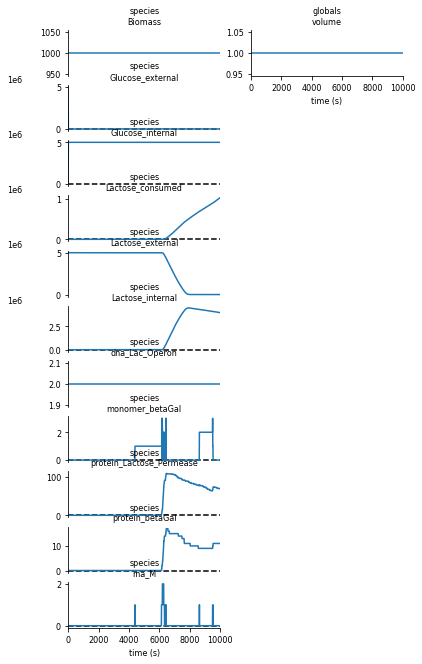

In [11]:
fig = plot_simulation_output(bioscrape_timeseries_stochastic)

# Multibody physics with pymunk

In [12]:
from vivarium_multibody.processes.multibody_physics import test_growth_division
from vivarium_multibody.processes.multibody_physics import agent_body_config, volume_from_length
from vivarium_multibody.plots.snapshots import (
    plot_snapshots,
    format_snapshot_data,
    make_snapshots_figure,
    get_field_range,
    get_agent_colors,
)
import numpy as np

from ipywidgets import interactive
import ipywidgets as widgets

In [13]:
total_time = 120
n_agents = 2
agent_ids = [
    str(agent_id)
    for agent_id in range(n_agents)]

# configure the multibody process
multibody_bounds = [40, 40]
multibody_config = {
    'bounds': multibody_bounds}
body_config = {
    'bounds': multibody_bounds,
    'agent_ids': agent_ids}
multibody_config.update(agent_body_config(body_config))

# experiment settings
experiment_settings = {'progress_bar': False, 'display_info': False}

# run multibody with grow/divide agents
multibody_data = test_growth_division(
        config=multibody_config,
        growth_rate=0.05,
        growth_rate_noise=0.05,
        division_volume=volume_from_length(4, 1),
        total_time=total_time,
        experiment_settings=experiment_settings)

multibody_agents, multibody_fields = format_snapshot_data(multibody_data)

In [14]:
try:
    time_index = 1
    time_indices = np.array([time_index])
    time_vec = list(agents.keys()) 

    # time_indices = np.round(np.linspace(0, len(time_vec) - 1, n_snapshots)).astype(int)
    snapshot_times = [time_vec[i] for i in time_indices]

    # get fields id and range
    multibody_field_range = get_field_range(fields, time_vec)

    # get agent ids
    multibody_agent_colors = get_agent_colors(multibody_agents)


    time_index_range = len(time_vec) -1

    def plot_single_snapshot(t_index):   
        time_indices = np.array([t_index])
        snapshot_time = [time_vec[t_index]]
        fig = make_snapshots_figure(
            time_indices=time_indices,
            snapshot_times=snapshot_time,
            agents=multibody_agents,
            agent_colors=multibody_agent_colors,
            fields=multibody_fields,
            field_range=multibody_field_range,
            n_snapshots=1,
            bounds=multibody_bounds,
            default_font_size=12,
            plot_width=6,
        )
except NameError as e:
    print("Something isn't working! Error:", e)

Something isn't working! Error: name 'agents' is not defined


In [15]:
try:
    interactive_plot = interactive(
        plot_single_snapshot, 
        t_index=widgets.IntSlider(min=0, max=time_index_range, step=1, value=0))
    interactive_plot
except NameError as e:
    print("Something isn't working! Error:", e)

Something isn't working! Error: name 'plot_single_snapshot' is not defined


# BioscrapeCOBRA: a CRN/FBA Composite

This also includes several adaptor "Deriver" Processes, such as FluxDeriver and BiomassAdaptor

* BiomassAdaptor demonstrates vivarium units, and also the use of a Deriver as an adaptor between Processes

## Flux Deriver

A Deriver is a kind of Process which can be used to convert values of one store into another type of value in another store. For example, this FluxDeriver converts amounts of species and changes in amounts of species to instantaneous fluxes.

This FluxDeriver is used in the composite to convert the changes of Lactose and Glucose from the CRN model into flux-bounds for the FBA model. In these cases "deltas" (changes in Species) are converted to fluxes by dividing by the timestep.

This FluxDeriver is also used to convert changes in biomass, output from the FBA model, into a dilution rate constant used by the CRN. This flux is computered differently because the change in biomass each timestep is not stored. Additionally, dilution rate must be calculated as a percentage of the current amount, not absolute flux, and be non-negative.

In [16]:
class FluxDeriver(Process):
    """ Bioscrape delta species to fluxes for constraining COBRA """
    
    defaults = {
        'time_step':1.0,
        'flux_keys': {}, #key --> {option dictionary}
        'default_options' : { #default options if option_dictionary is empty
            "input_type":"delta", #"delta" corresponds to changes between timesteps. "amount" corresponds to the absolute quantity
        }
    }
    def __init__(self, config = None):
        super().__init__(config)
        
        self.prev_inputs = {k:None for k in self.parameters["flux_keys"]}

    def initial_state(self, config=None):
        return {}

    def ports_schema(self):
        return {
            'inputs': {
                flux_key: {
                    '_default': 0.0}
                for flux_key in self.parameters['flux_keys']
            },
            'fluxes': {
                flux_key: {
                    '_updater': 'set',
                    '_emit':True }
                for flux_key in self.parameters['flux_keys']
            }
        }
    
    def compute_flux(self, flux_key, dt, inputs):
        #computes the flux for a specific flux key of the time interval dt
        
        input_type = self.parameters['flux_keys'][flux_key].get("input_type", self.parameters['default_options']["input_type"])
        
        #Set delta
        if input_type == "delta":
            delta = inputs[flux_key]
        elif input_type == 'amount':
            if self.prev_inputs[flux_key] is None:
                delta = 0
            else:
                delta = inputs[flux_key]-self.prev_inputs[flux_key]
        else:
            raise ValueError(f"Unknown input_type: {input_type} for flux_key {flux_key}")
        
        return delta / dt
     
    def next_update(self, timestep, states):
        inputs = states["inputs"]
        
        update = {}
        update['fluxes'] = {}
        
        for flux_key in self.parameters['flux_keys']:
            #flux_dt = self.get_flux_interval(flux_key, timestep)
            #if flux_dt is not None:
            update['fluxes'][flux_key] = self.compute_flux(flux_key, timestep, inputs)
            
        self.prev_inputs = inputs
        return update

    
class DilutionFluxDeriver(FluxDeriver):
    #This is a non-negative "percentage" flux used to control a dilution rate of a CRN from a the rate of growth in biomass
    
    def next_update(self, timestep, states):        
        inputs = states["inputs"]
        
        update = {}
        update['fluxes'] = {}
        
        for flux_key in self.parameters['flux_keys']:
            flux = self.compute_flux(flux_key, timestep, inputs)

            #Convert to a percent of the previous input
            if self.prev_inputs[flux_key] is None or (self.prev_inputs[flux_key] == 0 and states["inputs"][flux_key] == 0):
                #Edge case: If both the current amount and the previous amount were 0, return 0
                update['fluxes'][flux_key] = 0

            elif self.prev_inputs[flux_key] == 0 and states["inputs"][flux_key] > 0:
                #Edge case: If both the previous amount was 0, us the current amount for the normalization
                update['fluxes'][flux_key] = flux/states["inputs"][flux_key]

            else:
                #Standard case
                update['fluxes'][flux_key] = flux/self.prev_inputs[flux_key]

            #Enforce non-negativity
            if update['fluxes'][flux_key] < 0 :
                update['fluxes'][flux_key] = 0

                
        self.prev_inputs = inputs
        return update

class AverageFluxDeriver(FluxDeriver):
    #This is similar to a FluxDeriver, but fluxes are averaged between updates. This is useful to compute fluxes 
    #which are used by a process with a larger dt than the processes controlling the flux, for example a stochastic
    #CRN may be updated frequently but FBA may be updated less frequently.
    pass

## BiomassAdaptor Deriver

This adaptor is used to do unit conversion between the mass output from cobra and a Species used in the Bioscrape model to represent biomass.

In [17]:
class mass_to_concentration(Deriver):
    """ Adapts COBRA mass variable to Bioscrape biomass """
    
    defaults = {
        'input_mass_units':1.0 * units.fg,
        'input_volume_units':1.0 * units.fL,
        'output_concentration_units':1.0 *units.mmolar,
        'characteristic_output_volume':1.0 *units.fL,
        'mass_species_molecular_weight':1.0 *units.fg/units.molec
    }
    
    def initial_state(self, config=None):
        return {}

    def ports_schema(self):
        return {
            'input': {
                'mass': {
                    '_default': 1.0 * self.parameters["input_mass_units"],
                },
                'volume': {
                    '_default': 1.0 * self.parameters["input_volume_units"]}
            },
            'output': {
                # the value used by Bioscrape
                'biomass': {
                    '_default': 1.0,
                    '_update': 'set',
                }
            }
        }


    def next_update(self, timestep, states):
        mass = states['input']['mass']
        
        # do conversion
        #Concentration = mass/molecular_weight/characteristic volume
        #Note: Biomass is also used to set Volume, so here we just set the scale
        mass_species_conc = mass/self.config['mass_species_molecular_weight']/(self.config['characteristic_output_volume'])        
    
        update = {
            'output': {
                #Return the correct units, with units stripped away for bioscrape
                'biomass': mass_species_conc.to(self.config['output_concentration_units']).magnitude
                }
            }
        return update

class mass_to_count(Deriver):
    """ Adapts COBRA mass variable to Bioscrape biomass """
    
    defaults = {
        'input_mass_units':1.0 * units.fg,
        'mass_species_molecular_weight':1.0 *units.fg/units.molec
    }
    
    def initial_state(self, config=None):
        return {}

    def ports_schema(self):
        return {
            'input': {
                'mass': {
                    '_default': 1.0 * units.fg,
                },
            },
            'output': {
                # the value used by Bioscrape
                'biomass': {
                    '_default': 1.0,
                    '_update': 'set',
                }
            }
        }


    def next_update(self, timestep, states):
        mass = states['input']['mass']
        
        # do conversion
        #count = mass/molecular_weight
        #Note: Biomass is also used to set Volume, so here we just set the scale
        mass_species_count = mass/self.config['mass_species_molecular_weight']        
    
        update = {
            'output': {
                #Return the correct units, with units stripped away for bioscrape
                'biomass': mass_species_count.magnitude
                }
            }
        return update

# BioscrapeCOBRA Composite configurations

This composite demonstrates advanced generate_topology() methods, which split ports across multiple stores with `'_path'`

TODO:
    * units for Biomass is in mmol/L of a species with mw of 1 fg/count = avagadro's number * fg / mol
    * import of Glucose is also in terms of 'Biomass' species
    * stochastically, it is in counts. Volume
    * logic for counts/concentrations if stochastic/deterministic
    * Bioscrape species 'Lactose_internal', 'Lactose_external' need to get wired to ('external',),
        But don't let Bioscrape update them. Only use FBA's resulting uptake.


In [18]:
#choose the SBML file and set other bioscrape parameters
deterministic_bioscrape_config = {
            'sbml_file': 'LacOperon_deterministic.xml',
            'stochastic': False,
            'initial_volume': 1,
            'internal_dt': 0.01,}

# set cobra constrained reactions config
cobra_config = get_iAF1260b_config()
cobra_config.update({'time_step': 10})

#set up the config for the FluxDeriver
flux_config = {
    'flux_keys': {
        'Lactose_consumed': {}, #No options specified
        'Glucose_internal': {}  #No options specified
    },
}

dilution_rate_flux_config = {
    'time_step':cobra_config['time_step'],
    'flux_keys': {
        'biomass':{
            "input_type":"amount"
        }
    }
}

#Here we override the default ports schema of the Biomass species and the k_dilution rate in Bioscrape.
#This is done so they can be set by the Derivers connected to mass and mass flux from Cobra.
schema_override = {
    'bioscrape': {
        'species': {
            'Biomass': { 
                '_updater': 'set'  #override bioscrape ('species', 'Biomass') with a 'set' updater
            }
        },
        'rates':{
            'k_dilution__':{
                '_emit':True, #k_dilution should be emitted so it can be plotted
                '_updater':'set'
            }
        }
    }
}

In [19]:
class BioscrapeCOBRA(Composite):

    defaults = {
        'bioscrape': deterministic_bioscrape_config,
        'cobra': cobra_config,
        'flux_deriver': flux_config,
        'dilution_rate_flux':dilution_rate_flux_config,
        'divide_on': False, # is division turned on?
        'agent_id': np.random.randint(0, 100),
        'divide_condition': {
            'threshold': 2000 * units.fg},
        'agents_path': ('..', '..', 'agents',),
        'daughter_path': tuple(),
         '_schema': schema_override,
        'stochastic':False
    }

    def generate_processes(self, config):
        processes = {
            'bioscrape': Bioscrape(config['bioscrape']),
            'cobra': DynamicFBA(config['cobra']),
            'mass_deriver': TreeMass(),
            'volume_deriver': Volume(),
        }
        
        #Process Logic for different kinds of simulations
        
        #Deterministic case
        if not config['bioscrape']['stochastic']:
            #deterministic simulations have a variable dilution rate
            processes['dilution_rate_adaptor'] = DilutionFluxDeriver(config["dilution_rate_flux"])
            
            #flux is computed as an instaneous flux
            processes['flux_deriver'] = FluxDeriver(config['flux_deriver'])
            
            #biomass is converted to a concentration
            processes['biomass_adaptor'] = mass_to_concentration()
        
        #Stochastic Case
        else:
            #flux is computed as an average flux
            processes['flux_deriver'] = AverageFluxDeriver(config['flux_deriver'])
            
            #biomass is converted to a molecular count
            processes['biomass_adaptor'] = mass_to_count()
        
        #Division Logic
        if config['divide_on']:
            # division config
            daughter_path = config['daughter_path']
            agent_id = config['agent_id']
            division_config = dict(
                config.get('division', {}),
                daughter_path=daughter_path,
                agent_id=agent_id,
                generator=self)

            processes.update({
                'divide_condition': DivideCondition(config['divide_condition']),
                'division': MetaDivision(division_config)
            })
        return processes

    def generate_topology(self, config):

        topology = {
            'bioscrape': {
                # all species go to a species store on the base level,
                # except Biomass, which goes to the 'globals' store, with variable 'biomass'
                'species': {
                    '_path': ('species',),
                    'Biomass': ('..', 'globals', 'biomass'),
                },
                'delta_species': ('delta_species',),
                'rates': {
                    '_path' : ('rates',),
                },
                'globals': ('globals',),
            },
            'cobra': {
                'internal_counts': ('internal_counts',),
                'external': ('external',),
                'exchanges': ('exchanges',),
                'reactions': ('reactions',),
                'flux_bounds': ('flux_bounds',),
                'global': ('globals',),
            },
            'flux_deriver': {
                'inputs': ('delta_species',),
                #'amounts': ('globals',),
                # connect Bioscrape deltas 'Lactose_consumed' and 'Glucose_internal'
                # to COBRA flux bounds 'EX_lac__D_e' and 'EX_glc__D_e'
                
                'fluxes':{
                        '_path': ('flux_bounds',),
                        'Lactose_consumed': ('EX_lac__D_e',),
                        'Glucose_internal': ('EX_glc__D_e',),
                    }
            },
            
            'mass_deriver': {
                'global': ('globals',),
            },
            'volume_deriver': {
                'global': ('globals',),
            },
            'biomass_adaptor': {
                'input': ('globals',),
                'output': ('globals',),
            }
        }
        
        #Ports added only in the deterministic case
        if not config['stochastic']:
            #Create port biomass flux to the dilution rate computed by the dilution_rate_adaptor process
            topology['dilution_rate_adaptor']= {
                'inputs':('globals',),
                'fluxes':{
                    '_path':('rates',),
                    'biomass':('k_dilution__',)
                }
            }
            
        #Ports added only in the stochastic case
        else:
            pass
        
        if config['divide_on']:
            agents_path = config['agents_path']

            # connect divide_condition to the mass variable
            topology.update({
                'divide_condition': {
                    'variable': ('globals', 'mass',),
                    'divide': ('globals', 'divide',),
                },
                'division': {
                    'global': ('globals',),
                    'agents': agents_path,
                },
            })
        return topology

In [20]:
bioscrape_cobra_composite = BioscrapeCOBRA({})

#experiment = compartment_in_experiment(bioscrape_cobra_composite)
#pp(experiment.state.get_config(True))



In [21]:
# get initial state
initial_state = bioscrape_cobra_composite.initial_state()
## override FBA default external state
initial_state['external']['glc__D_e'] = 10
initial_state['external']['lcts_e'] = 10
#TODO Bioscrape and Cobra's external state's should be linked up.

# simulate
settings = {
    'initial_state': initial_state,
    'total_time': 500}
bioscrape_cobra_output = simulate_compartment_in_experiment(
    bioscrape_cobra_composite, 
    settings)

#plt.figure()
#plt.plot(bioscrape_cobra_output['time'], bioscrape_cobra_output['rates']['k_dilution__'])


Experiment ID: c7d78278-666e-11eb-9437-6c2b5976b3a5
Created: 02/03/2021 at 14:25:55


C:\ProgramData\Anaconda3\lib\site-packages\cobra\util\solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Completed in 10.41 seconds


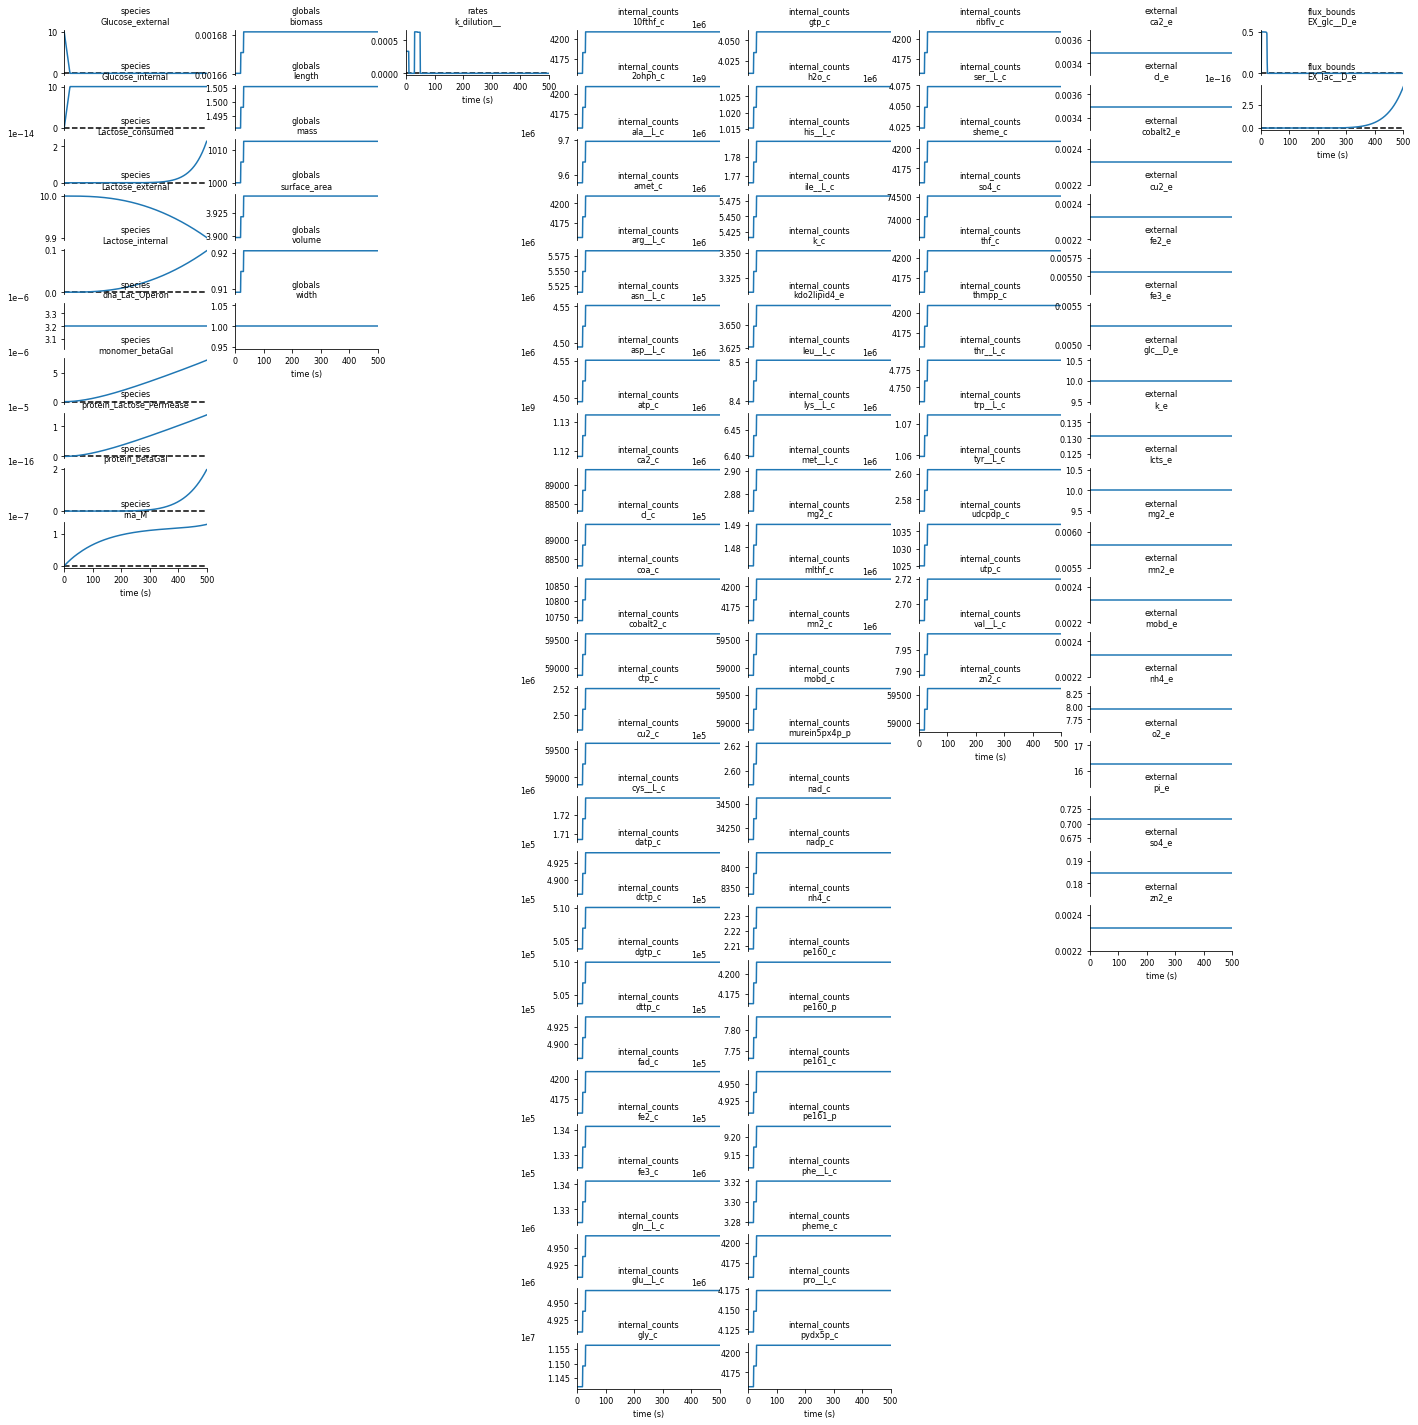

In [22]:
fig = plot_simulation_output(bioscrape_cobra_output)

# Stochastic Bioscrape-Cobra

Changes required for Stochastic Model
* New CRN Model without dilution and with initial conditions in counts instead of concentration
    * this means "k_dilution__" porting needs to removed from the topology
* BiomassDeriver converts to counts instead of concentration
* FluxDeriver run in "stochastic" mode where flux is averaged over the cobra update time-frame.

In [23]:
stochastic_bioscrape_config = {
            'sbml_file': 'LacOperon_stochastic.xml',
            'stochastic': True,
            'initial_volume': 1,
            'internal_dt': 0.01,}

bioscrape_cobra_composite_stochastic = BioscrapeCOBRA({"bioscrape":stochastic_bioscrape_config})
# get initial state
initial_state = bioscrape_cobra_composite_stochastic.initial_state()
## override FBA default external state
initial_state['external']['glc__D_e'] = 10**6
initial_state['external']['lcts_e'] = 10**6

# simulate
settings = {
    'initial_state': initial_state,
    'total_time': 1000}
bioscrape_cobra_output_stochastic = simulate_compartment_in_experiment(
    bioscrape_cobra_composite_stochastic, 
    settings)


Experiment ID: d3b4e430-666e-11eb-a6e8-6c2b5976b3a5
Created: 02/03/2021 at 14:26:14


C:\ProgramData\Anaconda3\lib\site-packages\vivarium_bioscrape-0.0.0.3-py3.7.egg\vivarium_bioscrape\processes\bioscrape.py:155: UserWarning: Trying to set parameter that is not in model: k_dilution__


states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 5000000.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

C:\ProgramData\Anaconda3\lib\site-packages\cobra\util\solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 4702058.0, 'Glucose_internal': 297942.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': -297942.0, 'Glucose_internal': 297942.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L'

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 2919436.0, 'Glucose_internal': 2080564.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': -296924.0, 'Glucose_internal': 296924.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 1141471.0, 'Glucose_internal': 3858529.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': -295401.0, 'Glucose_internal': 295401.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 5000000.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 0.0, 'Lactose_internal': 0.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K_

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': 4999993.0, 'Lactose_internal': 7.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 1.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 1.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -7.0, 'Lactose_internal': 7.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 1.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0, 'K

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 0.0, 'Lactose_external': 4999678.0, 'Lactose_internal': 322.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 2.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -73.0, 'Lactose_internal': 73.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 3.0, 'protein_betaGal': 0.0, 'Lactose_external': 4999217.0, 'Lactose_internal': 783.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 2.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -84.0, 'Lactose_internal': 84.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.0

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 3.0, 'protein_betaGal': 0.0, 'Lactose_external': 4998763.0, 'Lactose_internal': 1237.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 3.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -88.0, 'Lactose_internal': 88.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900000.

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 3.0, 'protein_betaGal': 0.0, 'Lactose_external': 4997792.0, 'Lactose_internal': 2208.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 5.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 0.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -188.0, 'Lactose_internal': 188.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 290000

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 1.0, 'Lactose_external': 4996505.0, 'Lactose_internal': 3493.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 7.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 2.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -250.0, 'Lactose_internal': 248.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 290000

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 1.0, 'Lactose_external': 4994898.0, 'Lactose_internal': 5100.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 8.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 2.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 0.0, 'Lactose_external': -238.0, 'Lactose_internal': 238.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 290000

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 1.0, 'Lactose_external': 4993119.0, 'Lactose_internal': 6876.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 9.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 5.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -289.0, 'Lactose_internal': 288.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 1.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 290000

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 2.0, 'Lactose_external': 4991240.0, 'Lactose_internal': 8749.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 10.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 11.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -351.0, 'Lactose_internal': 346.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 5.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 2900

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 2.0, 'Lactose_external': 4989181.0, 'Lactose_internal': 10801.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 10.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 18.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -344.0, 'Lactose_internal': 343.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 1.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 290

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 2.0, 'Lactose_external': 4986980.0, 'Lactose_internal': 12993.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 12.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 27.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -424.0, 'Lactose_internal': 424.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 0.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 290

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 3.0, 'Lactose_external': 4984120.0, 'Lactose_internal': 15847.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 15.0, 'dna_Lac_Operon': 2.0, 'Biomass': 999.9999847629246, 'Lactose_consumed': 33.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -494.0, 'Lactose_internal': 493.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 1.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 1.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 290

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 3.0, 'Lactose_external': 4980959.0, 'Lactose_internal': 18993.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 17.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1004.9593618452469, 'Lactose_consumed': 48.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -557.0, 'Lactose_internal': 553.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 4.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 29

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 1.0, 'protein_betaGal': 3.0, 'Lactose_external': 4977442.0, 'Lactose_internal': 22491.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 18.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1008.2533899410115, 'Lactose_consumed': 67.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -555.0, 'Lactose_internal': 553.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 1.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 2.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 29

states {'species': {'rna_M': 1.0, 'monomer_betaGal': 2.0, 'protein_betaGal': 3.0, 'Lactose_external': 4973559.0, 'Lactose_internal': 26354.0, 'Glucose_external': 0.0, 'Glucose_internal': 5000000.0, 'protein_Lactose_Permease': 19.0, 'dna_Lac_Operon': 2.0, 'Biomass': 1008.2533899410115, 'Lactose_consumed': 87.0}, 'delta_species': {'rna_M': 0.0, 'monomer_betaGal': 0.0, 'protein_betaGal': 0.0, 'Lactose_external': -673.0, 'Lactose_internal': 672.0, 'Glucose_external': 0.0, 'Glucose_internal': 0.0, 'protein_Lactose_Permease': 0.0, 'dna_Lac_Operon': 0.0, 'Biomass': 0.0, 'Lactose_consumed': 1.0}, 'rates': {'k_tl_beta_Gal__': 0.156666666666667, 'k_tl_lacP__': 0.313333333333333, 'BGal_tetramerization__': 1000.0, 'BGal_vmax__': 30.0, 'Bgal_Kd__': 700000.0, 'GluPermease_vmax__': 301.0, 'GluPermease_Kd__': 9033.0, 'LacPermease_reverse_vmax__': 1.18966666666667, 'LacPermease_Kd__': 8800000.0, 'kdeg_mRNA__': 0.00783333333333333, 'kdeg_prot__': 0.000166666666666667, 'Vtx': 0.003, 'n_L': 4.0, 'K_L': 29

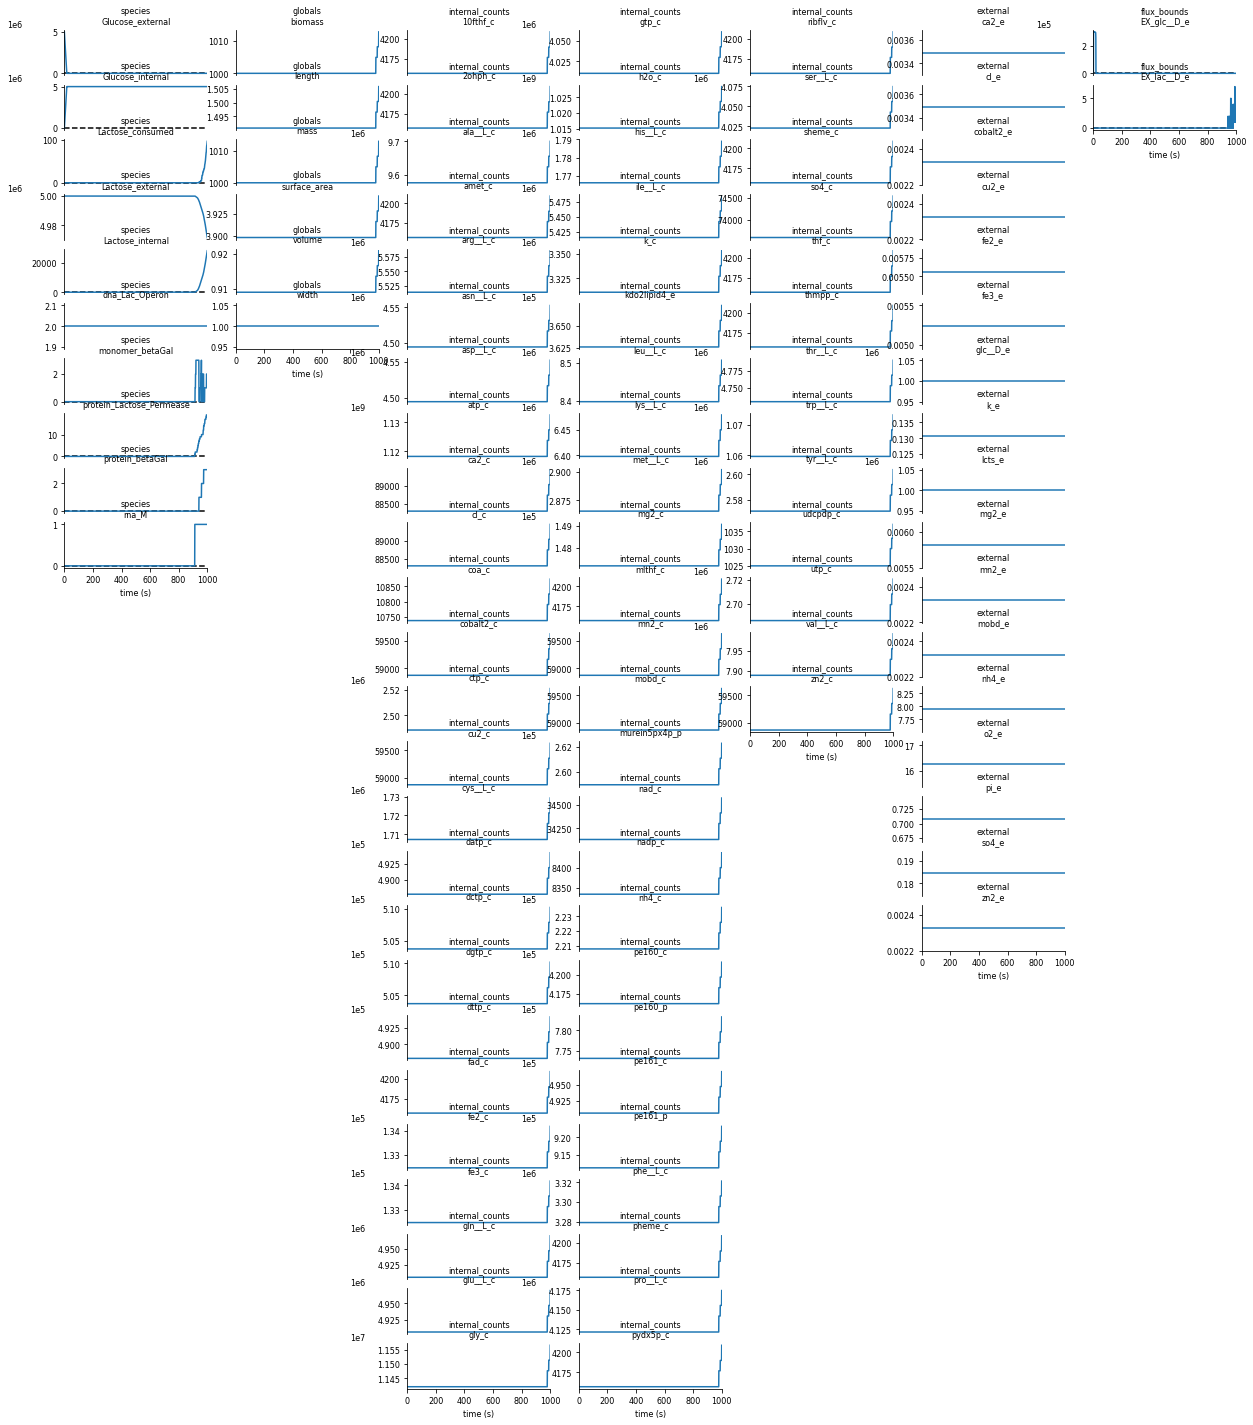

In [24]:
fig = plot_simulation_output(bioscrape_cobra_output_stochastic)

# Turning on Division

In [25]:
total_time = 2500

agent_id = '1'
division_config = {
    'divide_on': True,
    'agent_id': agent_id,
    'agents_path': ('..', '..', 'agents',),
}
division_composite = BioscrapeCOBRA(division_config)

# initial state
initial_state = division_composite.initial_state()
# initial_state['species']['Glucose_external'] = 2000
initial_state['external']['glc__D_e'] = 10
initial_state['external']['lcts_e'] = 10
initial_state = {
    'agents': {
        agent_id: initial_state}}

# run simulation
# simulate
settings = {
    'outer_path': ('agents', agent_id,),
    'initial_state': initial_state,
    'experiment_id': 'division'}
division_experiment = compartment_in_experiment(
    division_composite,
    settings=settings,
    initial_state=initial_state)




Experiment ID: division
Created: 02/03/2021 at 14:26:54


In [26]:
# run the experiment and extract the data
division_experiment.update(total_time)
division_output = division_experiment.emitter.get_data_unitless()

C:\ProgramData\Anaconda3\lib\site-packages\cobra\util\solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Completed in 56.06 seconds


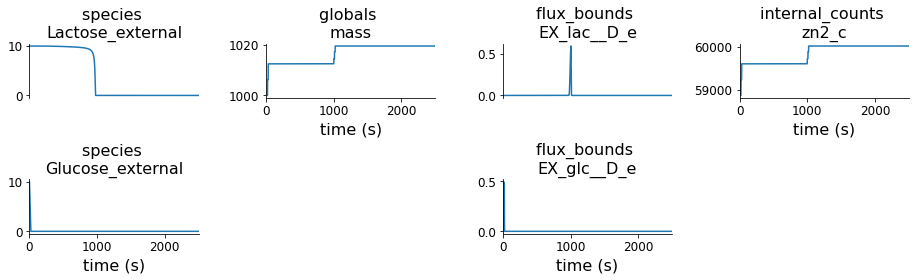

In [27]:
plot_settings = {
#     'skip_paths': [('external',)]
    'include_paths': [
        ('globals', 'mass'),
        ('species', 'Glucose_external'),
        ('species', 'Lactose_external'),
        ('flux_bounds', 'EX_glc__D_e'),
        ('flux_bounds', 'EX_lac__D_e'),
        ('internal_counts', 'zn2_c'),
        ],
}
fig = plot_agents_multigen(
    division_output,
    settings=plot_settings,
)

# Simulate BioscrapeCOBRA in a Spatial Environment with pymunk
 * We here plug BioscrapeCOBRA into an environmental composite called Lattice, which has a multi-body physics process (MBP) and a spatial diffusion process (DFF).

In [28]:
from vivarium_multibody.composites.lattice import Lattice, make_lattice_config

# declare configurations
agent_id = '1'
lattice_bounds = [20, 20]
env_config = {
    'time_step': 60,
    'bounds': lattice_bounds}

# declare the hierarchy
hierarchy = {
    FACTORY_KEY: {
        'type': Lattice,
        'config': make_lattice_config()},
    'agents': {
        agent_id: {
            FACTORY_KEY: {
                'type': BioscrapeCOBRA,
                'config': {
                    'divide_on': True,
                    'agent_id': agent_id,
                    'agents_path': ('..', '..', 'agents',),
                }}}}}


# configure experiment with helper function compose_experiment()
initial_state = division_composite.initial_state()
# initial_state['species']['Glucose_external'] = 2000
initial_state['external']['glc__D_e'] = 10
initial_state['external']['lcts_e'] = 10
initial_state = {
    'agents': {
        agent_id: initial_state}}

experiment_settings = {
    'initial_state': initial_state,
    'experiment_id': 'spatial_environment'}

OSError: [WinError 126] The specified module could not be found

In [ ]:
# make the experiment
spatial_experiment = compose_experiment(
    hierarchy=hierarchy, 
    settings=experiment_settings)

# run the experiment
spatial_experiment.update(1000)

# retrieve the data
spatial_data = spatial_experiment.emitter.get_data_unitless()
agents, fields = format_snapshot_data(spatial_data)

In [ ]:
fig = plot_snapshots(
    bounds=lattice_bounds, 
    agents=agents, 
    fields=fields)